# __Autoencoder Multi-Class__
---

La classification par autoencoder fonctionne de la façon suivante :
- Dans un premier temps, on utilise un encoder pour réduire les images et détecter les zones importantes.
- Dans un second temps, on utilise un classificateur classique pour classer les images.

Nous allons utiliser un autoencoder fully-connected, entrainer notre modèle et récupérer la partie encoder.

![Alternative text](https://www.researchgate.net/publication/331230358/figure/fig4/AS:959315259162633@1605729989983/The-schematic-architecture-of-a-classifier-autoencoder-A-gene-expression-profile-GEP.png)

## __Importation des bibliothèques__

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import datetime
import cv2
import shutil
from tensorflow import keras, losses
from keras import backend as K

## __Création des jeux de données d'entrainement, de validation et de test__

À partir du jeu de données fourni de la phase de pré-processing, il nous suffit de créer les différents Tensor pour réaliser nos différents tests.

Dans un premier temps, nous créons les jeux de données d'entrainement et de validation. Pour cela, nous nous rendons dans le dossier 'Multi-Class' de notre dataset et nous prenons le dossier 'Train'. Nous prenons ce dossier pour les deux jeux de données.

Ensuite, nous devons faire un split de ces jeux de données. Pour cela, il faut utiliser le paramètre 'Validation_split'. Nous redimensionnons les images en 128 par 128 pixels, et nous donnons les subsets 'Training' et 'Validation'.

In [2]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    directory=r"D:\Quentin\Etudes\Cesi\A5\Option Data\Projet\Autoencoder\dataset_reduit",
    labels="inferred",
    validation_split=0.2,
    label_mode="categorical",
    class_names=['Painting', 'Photo', 'Schematics', 'Sketch', 'Text'],
    seed=41,
    subset='training',
    image_size=(128,128),
    interpolation="bilinear",
    follow_links=False,
)
validate = tf.keras.preprocessing.image_dataset_from_directory(
    directory=r"D:\Quentin\Etudes\Cesi\A5\Option Data\Projet\Autoencoder\dataset_reduit",
    labels="inferred",
    validation_split=0.2,
    label_mode="categorical",
    class_names=['Painting', 'Photo', 'Schematics', 'Sketch', 'Text'],
    seed=41,
    subset='validation',
    image_size=(128,128),
    interpolation="bilinear",
    follow_links=False,
)

Found 1015 files belonging to 5 classes.
Using 812 files for training.
Found 1015 files belonging to 5 classes.
Using 203 files for validation.


Pour le jeu de données de test, il faut prendre le dossier 'test' dans le dossier 'Multi-class'. Nous n'avons pas besoin de séparer nos données ou de créer un subset.

In [3]:
test = tf.keras.preprocessing.image_dataset_from_directory(
    directory=r"D:\Quentin\Perso\dataset\multi-class\test",
    labels="inferred",
    label_mode="categorical",
    class_names=['Painting', 'Photo', 'Schematics', 'Sketch', 'Text'],
    seed=41,
    subset=None,
    image_size=(128,128),
    interpolation="bilinear",
    follow_links=False,
)

Found 8199 files belonging to 5 classes.


## __Autoencoder__

### *Normalisation des données*
Il est possible d'utiliser un autoencoder afin de faire une classification. Dans un premier temps, nous créons un encoder décodeur.

Pour cela, il faut d'abords normaliser nos données. Cela nous permettra d'avoir un meilleur résultat.

Nous utilisons la méthode Rescaling, dans le but de redimensionner toutes les données entre 0 et 1.

In [4]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
def change_inputs(images, labels):
  x = tf.image.resize(normalization_layer(images),[128, 128], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return x, x
normalized_ds = train.map(change_inputs)
normalized_validate = validate.map(change_inputs)
normalized_test = test.map(change_inputs)

### *Création de la fonction d'Autoencoder*
Ensuite, nous créons l'autoencoder. Il est composé de deux parties :
- L'encoder, qui va permettre de réduire les images, et qui sera utile pour le classificateur.
- Le décoder, qui sera utile pour l'entrainement du modèle. Il sera ensuite retiré lors des prédictions.

#### Création de l'encoder
Dans un premier temps, nous créons l'encoder. On commence par créer l'encoder.

- Nous commençons par créer notre couche d'entrée, qui correspond au nombre de pixels de notre image.

- Nous récupérons cette entrée pour faire un Flatten(), afin de mettre toutes les entrées sur une seule ligne.

- Nous créons ensuite deux couches, une de 4 096 entrées avec une fonction d'activation 'RElu', et une couche de batchnormalization. Cette fonction permet de normaliser la sortie de la couche précédente afin de facilité l'apprentissage dans la couche suivante. Cette fonction de normalisation s'effectue sur chacun des batchs de notre jeu de données.

- Nous terminons par créer notre couche d'espace latent, qui récupère les images réduites.

À la fin de ces étapes, nous créons modèle d'encoder, avec comme entrée la variable 'encoder_inputs' et comme sortie la variable 'latent_space'.

#### Création du décoder
La structure du décoder va ressembler à celui de l'encoder.

- Nous récupérons la sortie de l'encoder, qui se trouve dans la variable 'latent_space' pour créer la couche d'entrée du décoder. Nous ne mettons que 64 comme taille d'entrée, car c'est la taille de la variable 'latent_space'.

- Nous créons ensuite deux couches, une de 4 096 entrées avec une fonction d'activation 'RElu', et une couche de batchnormalization.

- Nous créons une autre couche avec 49 152 entrées et nous utilisons la fonction d'activation 'sigmoid'. Utiliser cette fonction est plus efficace pour la recomposition de l'image.

- Enfin, nous allons utiliser la fonction Reshape, afin de restaurer les images dans leur forme d'origine. Si nous ne faisons pas ce redimensionnement, nous ne pourrions pas faire la comparaison entre les images d'entrées et les images de sorties.

À la fin de ces étapes, nous créons modèle du décoder, avec comme entrée la variable 'decoder_inputs' et comme sortie la variable 'output'.

#### Fusion de l'encoder et du décoder pour créer l'autoencoder
Une fois que l'encoder et le décoder créés, nous utilisons la même méthode pour créer l'autoencoder, en utilisant comme variable d'entrée 'encoder_inputs' et comme variable de sortie 'outputs'.

In [5]:
def create_autoencoder(data_train, data_validation, nb_epochs, save_weights_path):
    latent_space_dim = 64
# Architecture de l'Encodeur
    encoder_inputs = tf.keras.Input(shape=(128, 128, 3))
    flatten = tf.keras.layers.Flatten()(encoder_inputs)
    hidden3 = tf.keras.layers.Dense(4096, activation='relu')(flatten)
    hidden4 =  tf.keras.layers.BatchNormalization()(hidden3)
    latent_space = tf.keras.layers.Dense(latent_space_dim, activation='relu')(hidden4)

    encoder = keras.Model(encoder_inputs, latent_space, name="encoder")

# Architecture du Décodeur  
    decoder_inputs = tf.keras.Input(shape=(64,))
    hidden9 = tf.keras.layers.Dense(4096, activation='relu')(decoder_inputs)
    hidden10 = tf.keras.layers.BatchNormalization()(hidden9)
    decoder_outputs = tf.keras.layers.Dense(49152, activation='sigmoid')(hidden10)
    output = tf.keras.layers.Reshape(target_shape=(128, 128 ,3))(decoder_outputs)

    decoder = keras.Model(decoder_inputs, output, name="decoder")

# Combinaison des deux Architecture (Enc,Dec)
    outputs = decoder(latent_space)
    autoencoder = keras.Model(encoder_inputs, outputs, name="autoencoder")
    autoencoder.summary()

# Compilation du modèle
    autoencoder.compile(optimizer='adam', loss= 'mse', metrics=['accuracy'])

# Exécution du modèle
    history = autoencoder.fit(data_train, epochs=nb_epochs,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(data_validation))

# Sauvegarde des paramètres
    autoencoder.save(r"D:\Quentin\Etudes\Cesi\A5\Option Data\Projet\Autoencoder\poids\model_deux.h5")
    encoder.save(r"D:\Quentin\Etudes\Cesi\A5\Option Data\Projet\Autoencoder\poids\encoder_deux.h5")

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    return history

#### Compilation
Lors de la Compilation du modèle, nous utilisons l'optimizer 'Adam' ainsi que la fonction de perte MSE. Le but de la MSE, où Mean Squared Error, est de calculer le carré de la différence entre la valeur prédite et la valeur réel. Nous faisons ensuite une moyenne sur ces valeurs. Nous utilisons la MSE comme fonction perte, car elle apporte de bons résultats avec des données comme les images.

#### Apprentissage
Enfin vient le moment de l'entrainement du modèle. Pour cela, dans les paramètres de la fonction fit, nous définissons la taille des batchs à 32. Nous définissons plus loin le nombre d'époques à utiliser, qui est de 10.

#### Sauvegarde des poids
Nous terminons cette méthode de création d'un autoencoder par l'enregistrement des poids. Dans un premier temps, nous enregistrons l'ensemble des poids de l'autoencoder. Il pourrait nous servir lors de la phase de traitement d'images ou pour d'autres projets. Il peut vous être utile afin d'éviter de lancer tout le code.

Enfin, nous enregistrons les poids de la partie encoder. C'est cette partie qui nous intéresse pour la classification.

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 4096)              201330688 
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                262208    
                                                                 
 decoder (Functional)        (None, 128, 128, 3)       201658368 
                                                       

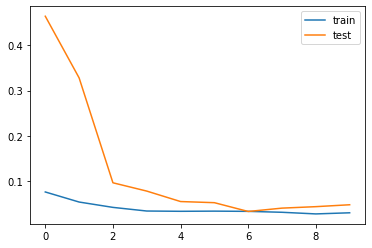

In [6]:
ae = create_autoencoder(normalized_ds, normalized_validate, 10, "D:\\Quentin\\Etudes\\Cesi\\A5\\Option Data\\Projet\\Autoencoder\\poids")

#### Interprétation des résultats
Nous nous rendons compte, au vu du graphique ci-dessus, que notre autoencoder est assez performant. En effet, nous pouvons voir que notre modèle arrive à généraliser sur les données. Mais ce test n'a pas été réalisé qu'avec un échantillon de 1000 images.

Ce modèle est en réalité assez peu performant, ce qui est principalement du au nombre limité de couches dans notre réseau. En effet, nous ne pouvions pas mettre beaucoup de couches avec une réduction et une augmentation rapide des images, car le nombre de paramètres serait trop élevé et le temps d'entrainement de notre modèle aurait été trop élevé.

Une autre conséquence de cette performance est l'aspect Fully-Connected de notre réseau. Cela augmente le nombre de paramètres, et donc le temps d'entrainement du modèle.

Code pour charger les poids d'un modèle :

In [7]:
saved_model = tf.keras.models.load_model(r"D:\Quentin\Etudes\Cesi\A5\Option Data\Projet\Autoencoder\poids\model_un.h5")


KeyboardInterrupt



### *Classifier*
Le classifier est la partie qui va permettre de classer les images encodées. La structure du modèle est de la forme suivante :
- Nous commençons par faire un Flatten() en récupérant la sortie de l'encoder.
- Ensuite, nous faisons 4 couches de neurones de 64, 32, 16 et 5, où 5 est le nombre de classes de nos images.
- Nous compilons le modèle avec l'optimizer 'adam' et la fonction de perte 'SparseCategoricalCrossentropy'.

In [ ]:
classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.Flatten(input_shape=(812, 64)))
classifier.add(tf.keras.layers.Dense(64, activation='relu'))
classifier.add(tf.keras.layers.Dense(32, activation='relu'))
classifier.add(tf.keras.layers.Dense(16, activation='relu'))
classifier.add(tf.keras.layers.Dense(5, activation='relu'))
classifier.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


### *Problèmes rencontrés*
L'autoencoder Classifier n'est pas encore terminé. Nous rencontrons des difficultés avec la taille de la sortie de l'encoder avec l'entrée du classifier.

In [ ]:
encoder = tf.keras.models.load_model(r"D:\Quentin\Etudes\Cesi\A5\Option Data\Projet\Autoencoder\poids\encoder_deux.h5")
X_train_encoded = encoder.predict(normalized_ds)
Y_train_encoded = encoder.predict(normalized_validate)


7/7 [==============================] - 2s 126ms/step


In [ ]:
classifier.fit(X_train_encoded, validation_data=(Y_train_encoded),
            epochs=5,
            batch_size=32,
            shuffle=True)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()